<a href="https://colab.research.google.com/github/jaehyun0220/Colab/blob/master/Media_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#10조. 네이버 댓글 분석을 통한 상위, 하위 클립 예측

In [1]:
# Auth 인증 및 Google Drive 활용 Data load
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
!ls ../gdrive/My\ Drive/output

file_ep10.csv	 file_ep16.csv	file_ep22.csv  file_ep4.csv
file_ep11.csv	 file_ep17.csv	file_ep23.csv  file_ep5.csv
file_ep12.csv	 file_ep18.csv	file_ep24.csv  file_ep6.csv
file_ep13.csv	 file_ep19.csv	file_ep25.csv  file_ep7.csv
file_ep14_1.csv  file_ep1.csv	file_ep26.csv  file_ep8.csv
file_ep14.csv	 file_ep20.csv	file_ep2.csv   file_ep9.csv
file_ep15.csv	 file_ep21.csv	file_ep3.csv   TheLastEmpress.csv


In [3]:
!pip install regex

     |████████████████████████████████| 645kB 3.5MB/s 


In [4]:
# 기본 라이브러리 로드
import pandas as pd
import numpy as np
import os, sys
import regex as re

from tqdm import tqdm_notebook

import re
import tensorflow as tf

#데이터 전처리 관련 라이브러리 로드
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit

#모델 알고리즘 로드
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

# Deep Learning Model 로드
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier

#차원축소 알고리즘 로드
from sklearn.decomposition import PCA

#HyperParameter Tuning을 위한 라이브러리 로드
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#모델 평가를 위한 라이브러리 로드
from sklearn import metrics, model_selection
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

#데이터 분리를 위한 라이브러리 로드
from sklearn.model_selection import train_test_split

#수학 & 통계 관련 라이브러리 로드
import scipy.stats as st
from collections import Counter
import math

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Visualization
import seaborn as sns
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도


#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

Using TensorFlow backend.


In [5]:
filelist = os.listdir('../gdrive/My Drive/output')
filelist

['file_ep1.csv',
 'file_ep16.csv',
 'file_ep17.csv',
 'file_ep10.csv',
 'file_ep14.csv',
 'file_ep12.csv',
 'file_ep11.csv',
 'file_ep14_1.csv',
 'file_ep15.csv',
 'file_ep13.csv',
 'file_ep18.csv',
 'file_ep19.csv',
 'file_ep21.csv',
 'file_ep20.csv',
 'file_ep2.csv',
 'file_ep22.csv',
 'file_ep23.csv',
 'file_ep25.csv',
 'file_ep24.csv',
 'file_ep26.csv',
 'file_ep3.csv',
 'file_ep4.csv',
 'file_ep5.csv',
 'file_ep6.csv',
 'file_ep9.csv',
 'file_ep7.csv',
 'TheLastEmpress.csv',
 'file_ep8.csv']

In [6]:
# 총 26회차 491개 하이라이트 클립 존재 (전체 재생수 = 107,221,654 / 클립 당 평균 재생수 = 218,374), 
# 이 중에서 예고편, 미공개, 인터뷰 등 클립 제외하고 총 422회 클립 대상
df_title = pd.read_csv('../gdrive/My Drive/output/TheLastEmpress.csv', encoding = 'euc-kr')
df_title.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)

# 조회수 분포를 고려하여 각 회차별로 조회수 상위 4개, 하위 4개 클립을 샘플링 - 총 208개 클립
# 좋아요수, 댓글 수, 댓글 내용, 댓글 작성자 정보 (웹크롤링 통한 추출)

df_ep_tot = pd.DataFrame()
for i in tqdm_notebook(filelist):
  if (i[:4] == 'file'):
    df_ep_temp = pd.read_csv('../gdrive/My Drive/output/'+i)
    df_ep_temp['play'] = df_ep_temp['play'].apply(lambda x: int(re.sub(',','', x[4:])))
    df_ep_temp['rank'] = df_ep_temp['play'].rank(method='dense', ascending=False)
    df_ep_tot = df_ep_tot.append(df_ep_temp)

df_ep_tot.drop(columns='Unnamed: 0', inplace=True)
df_ep_tot['target'] = np.where(df_ep_tot['rank']<=4,1,0)
df_ep_tot

,nick,contents,recomm,unrecomm,title,play,like,reple_count,episode,rank,target
0,rosi****,ㅅㅂ옷입고 목욕탕 들어가는거 ㅈㄴ웃기넼ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ저거 명품일 텐데ㅋㅋㅋㅋ...,5,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
1,핑크에메랄드,왠지 선황제가 바람은 못폈을거 같다는 생각이 든다 태후가 황후로 있는한 감히 생각도...,2,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
2,서지안,ㅋㅋㅋㅋㅋㅋㅋㅋ,0,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
3,경,ㅏ,0,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
4,홍홍,이게 나라냐? 방송에서 이딴수위가 나오고 지랄이야 진짜 개좃헬조선 시발,3,5,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
1841,Major,와 ㅅㅂ...피지컬봐....,550,1,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0
1842,스폰지밥,"이쁘십니다 할때 나만설렜냐,,,,,,,",691,4,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0
1843,박한별,반했네,372,4,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0
1844,김민정,죄송하지만 이 분 이용합시다 ! 어쨌든 좋은게 좋은거죠 ..,593,4,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0


In [7]:
display(df_title.head())
display(df_title.info())

,episode,title,play
0,14,"[숨멎 엔딩] 신성록, 설렘 폭발하는 반전 섹시미!",892539
1,8,"장나라, 악녀 이엘리야 때려잡는 카리스마 “얻다대고 반말”",852569
2,19,신은경 완벽 빙의한 ‘오아린 더빙 연기’,811897
3,10,"“사랑해요 폐하” 장나라, 신성록 계획 박살 내며 ‘흑화 스위치 ON’",757992
4,10,"뛰는 이엘리야 위 나는 오아린, 혼신의 눈물 연기(Feat. 윤소이 불꽃 따귀)",725808


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Data columns (total 3 columns):
episode    422 non-null int64
title      422 non-null object
play       422 non-null int64
dtypes: int64(2), object(1)
memory usage: 10.0+ KB


None

In [8]:
display(df_ep_tot.head())
display(df_ep_tot.info())
# df_ep_tot[df_ep_tot['episode'] == 1].sample(10).sort_values(by='play', ascending = False)

,nick,contents,recomm,unrecomm,title,play,like,reple_count,episode,rank,target
0,rosi****,ㅅㅂ옷입고 목욕탕 들어가는거 ㅈㄴ웃기넼ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ저거 명품일 텐데ㅋㅋㅋㅋ...,5,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
1,핑크에메랄드,왠지 선황제가 바람은 못폈을거 같다는 생각이 든다 태후가 황후로 있는한 감히 생각도...,2,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
2,서지안,ㅋㅋㅋㅋㅋㅋㅋㅋ,0,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
3,경,ㅏ,0,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
4,홍홍,이게 나라냐? 방송에서 이딴수위가 나오고 지랄이야 진짜 개좃헬조선 시발,3,5,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 40935 entries, 0 to 1845
Data columns (total 11 columns):
nick           40935 non-null object
contents       40801 non-null object
recomm         40935 non-null int64
unrecomm       40935 non-null int64
title          40935 non-null object
play           40935 non-null int64
like           40935 non-null object
reple_count    40935 non-null object
episode        40935 non-null int64
rank           40935 non-null float64
target         40935 non-null int64
dtypes: float64(1), int64(5), object(5)
memory usage: 3.7+ MB


None

In [0]:
# for name, group in df_ep.groupby(by='title'):
#   print(name)
#   print(group['like'].rank(method='min'))

### 1화 댓글 대상 sample set test

In [10]:
df_ep_sample = df_ep_tot[df_ep_tot['episode'] == 1].copy()
df_ep_sample

,nick,contents,recomm,unrecomm,title,play,like,reple_count,episode,rank,target
0,rosi****,ㅅㅂ옷입고 목욕탕 들어가는거 ㅈㄴ웃기넼ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ저거 명품일 텐데ㅋㅋㅋㅋ...,5,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
1,핑크에메랄드,왠지 선황제가 바람은 못폈을거 같다는 생각이 든다 태후가 황후로 있는한 감히 생각도...,2,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
2,서지안,ㅋㅋㅋㅋㅋㅋㅋㅋ,0,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
3,경,ㅏ,0,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
4,홍홍,이게 나라냐? 방송에서 이딴수위가 나오고 지랄이야 진짜 개좃헬조선 시발,3,5,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
487,싹스리,ㆍ연기가 좀 오바한다 좀 자연스럽게 스테파니야,4,5,"스테파니 리, 철딱서니 없는 도박 중독 윤다훈에 격노 ‘그 손 잘라버려!’",55267,172,7,1,8.0,0
488,갓갓,본방 사운드도 이상하더니ㅋㅋㅋㅋㅋㅋㅋ스브스 왜그래.... 노답,57,2,"스테파니 리, 철딱서니 없는 도박 중독 윤다훈에 격노 ‘그 손 잘라버려!’",55267,172,7,1,8.0,0
489,뿅뿅,영상 소리 안나와요ㅡㅡ 올리고 확인좀...,38,2,"스테파니 리, 철딱서니 없는 도박 중독 윤다훈에 격노 ‘그 손 잘라버려!’",55267,172,7,1,8.0,0
490,뽀글이,힘내♡,24,4,"스테파니 리, 철딱서니 없는 도박 중독 윤다훈에 격노 ‘그 손 잘라버려!’",55267,172,7,1,8.0,0


In [11]:
!pip3 install konlpy

     |████████████████████████████████| 19.4MB 410kB/s 
     |████████████████████████████████| 92kB 7.8MB/s 
     |████████████████████████████████| 2.7MB 28.9MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [0]:
import konlpy
from konlpy.tag import Kkma, Okt
from konlpy.utils import pprint

okt =Okt()
kkma = Kkma()
# mecab = Mecab()
# pprint(kkma.sentences(u'네, 안녕하세요. 반갑습니다.'))

# sentence = u'만 6세 이하의 초등학교 취학 전 자녀를 양육하기 위해서는'
# words = konlpy.tag.Twitter().pos(sentence)
# print(words)

In [0]:
def morphs_okt(x):
  res = okt.morphs(x)
  if len(res) >= 1:
    res = [re.sub('[ㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣ ]', '', res[i]) for i in range(len(res)) if re.sub('[ㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣ ]', '', res[i]) != '' and len(res[i]) >= 1]
  else:
    res = ''
  res = '' if not res else res
  return res

def morphs_kkma(x):
  res = kkma.morphs(x)
  if len(res) >= 1:
    res = [re.sub('[ㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣ ]', '', res[i]) for i in range(len(res)) if re.sub('[ㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣ ]', '', res[i]) != '' and len(res[i]) >= 1]
  else:
    res = ''
  res = '' if not res else res
  return res

# def morphs_mecab(x):
#   res = kkma.morphs(x)
#   if len(res) > 1:
#     res = [re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》ㅋㅡ ]', '', res[i]) for i in range(len(res)) if len(res[i]) > 1]
#   else:
#     res = ''
#   return res

In [14]:
df_ep_sample['contents'] = df_ep_sample['contents'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df_ep_sample['okt_token'] = df_ep_sample['contents'].apply(lambda x: morphs_okt(x))
df_ep_sample['kkma_token'] = df_ep_sample['contents'].apply(lambda x: morphs_kkma(x))
df_ep_sample['okt_token_str'] = df_ep_sample['okt_token'].apply(lambda x: ' '.join(x))
df_ep_sample['kkma_token_str'] = df_ep_sample['kkma_token'].apply(lambda x: ' '.join(x))
df_ep_sample

,nick,contents,recomm,unrecomm,title,play,like,reple_count,episode,rank,target,okt_token,kkma_token,okt_token_str,kkma_token_str
0,rosi****,ㅅㅂ옷입고 목욕탕 들어가는거 ㅈㄴ웃기넼ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ저거 명품일 텐데ㅋㅋㅋㅋ...,5,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1,"[옷, 입고, 목욕탕, 들어가는거, 웃기, 넼, 저, 거, 명품, 일, 텐데]","[옷, 입, 고, 목욕탕, 들어가, 는, 거, 웃기, 넼, 저거, 명품, 이, 터,...",옷 입고 목욕탕 들어가는거 웃기 넼 저 거 명품 일 텐데,옷 입 고 목욕탕 들어가 는 거 웃기 넼 저거 명품 이 터 이 데
1,핑크에메랄드,왠지 선황제가 바람은 못폈을거 같다는 생각이 든다 태후가 황후로 있는한 감히 생각도...,2,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1,"[왠지, 선, 황제, 가, 바람, 은, 못, 폈을거, 같다는, 생각, 이, 든다, ...","[왠지, 선, 황제, 가, 바람, 은, 못, 피, 었, 을, 거, 같, 다는, 생각...",왠지 선 황제 가 바람 은 못 폈을거 같다는 생각 이 든다 태후 가 황후 로 있는한...,왠지 선 황제 가 바람 은 못 피 었 을 거 같 다는 생각 이 들 다 태 후 가 황...
2,서지안,ㅋㅋㅋㅋㅋㅋㅋㅋ,0,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1,,,,
3,경,ㅏ,0,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1,,,,
4,홍홍,이게 나라냐 방송에서 이딴수위가 나오고 지랄이야 진짜 개좃헬조선 시발,3,5,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1,"[이, 게, 나라, 냐, 방송, 에서, 이딴, 수위, 가, 나오고, 지랄, 이야, ...","[이것, 이, 나라, 이, 냐, 방송, 에서, 이딴, 수위, 가, 나오, 고, 지랄...",이 게 나라 냐 방송 에서 이딴 수위 가 나오고 지랄 이야 진짜 개 좃헬 조선 시발,이것 이 나라 이 냐 방송 에서 이딴 수위 가 나오 고 지랄 이 야 진짜 개 좃 헤...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,싹스리,연기가 좀 오바한다 좀 자연스럽게 스테파니야,4,5,"스테파니 리, 철딱서니 없는 도박 중독 윤다훈에 격노 ‘그 손 잘라버려!’",55267,172,7,1,8.0,0,"[연기, 가, 좀, 오, 바, 한다, 좀, 자연, 스럽게, 스테파니, 야]","[연기, 가, 좀, 오, 바, 하, 다, 좀, 자연, 스럽, 게, 스테파니, 야]",연기 가 좀 오 바 한다 좀 자연 스럽게 스테파니 야,연기 가 좀 오 바 하 다 좀 자연 스럽 게 스테파니 야
488,갓갓,본방 사운드도 이상하더니ㅋㅋㅋㅋㅋㅋㅋ스브스 왜그래 노답,57,2,"스테파니 리, 철딱서니 없는 도박 중독 윤다훈에 격노 ‘그 손 잘라버려!’",55267,172,7,1,8.0,0,"[본방, 사운드, 도, 이상하더니, 스브스, 왜, 그래, 노답]","[본방, 사운드, 도, 이상, 하, 더니, 스브스, 왜, 그리하, 여, 노, 답]",본방 사운드 도 이상하더니 스브스 왜 그래 노답,본방 사운드 도 이상 하 더니 스브스 왜 그리하 여 노 답
489,뿅뿅,영상 소리 안나와요ㅡㅡ 올리고 확인좀,38,2,"스테파니 리, 철딱서니 없는 도박 중독 윤다훈에 격노 ‘그 손 잘라버려!’",55267,172,7,1,8.0,0,"[영상, 소리, 안, 나와요, 올리고, 확인, 좀]","[영상, 소리, 안, 나오, 아요, 올리, 고, 확인, 좀]",영상 소리 안 나와요 올리고 확인 좀,영상 소리 안 나오 아요 올리 고 확인 좀
490,뽀글이,힘내,24,4,"스테파니 리, 철딱서니 없는 도박 중독 윤다훈에 격노 ‘그 손 잘라버려!’",55267,172,7,1,8.0,0,[힘내],[힘내],힘내,힘내


In [15]:
df_ep_token = df_ep_sample.drop(df_ep_sample[df_ep_sample['okt_token'] == ''].index)
df_ep_token

,nick,contents,recomm,unrecomm,title,play,like,reple_count,episode,rank,target,okt_token,kkma_token,okt_token_str,kkma_token_str
0,rosi****,ㅅㅂ옷입고 목욕탕 들어가는거 ㅈㄴ웃기넼ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ저거 명품일 텐데ㅋㅋㅋㅋ...,5,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1,"[옷, 입고, 목욕탕, 들어가는거, 웃기, 넼, 저, 거, 명품, 일, 텐데]","[옷, 입, 고, 목욕탕, 들어가, 는, 거, 웃기, 넼, 저거, 명품, 이, 터,...",옷 입고 목욕탕 들어가는거 웃기 넼 저 거 명품 일 텐데,옷 입 고 목욕탕 들어가 는 거 웃기 넼 저거 명품 이 터 이 데
1,핑크에메랄드,왠지 선황제가 바람은 못폈을거 같다는 생각이 든다 태후가 황후로 있는한 감히 생각도...,2,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1,"[왠지, 선, 황제, 가, 바람, 은, 못, 폈을거, 같다는, 생각, 이, 든다, ...","[왠지, 선, 황제, 가, 바람, 은, 못, 피, 었, 을, 거, 같, 다는, 생각...",왠지 선 황제 가 바람 은 못 폈을거 같다는 생각 이 든다 태후 가 황후 로 있는한...,왠지 선 황제 가 바람 은 못 피 었 을 거 같 다는 생각 이 들 다 태 후 가 황...
4,홍홍,이게 나라냐 방송에서 이딴수위가 나오고 지랄이야 진짜 개좃헬조선 시발,3,5,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1,"[이, 게, 나라, 냐, 방송, 에서, 이딴, 수위, 가, 나오고, 지랄, 이야, ...","[이것, 이, 나라, 이, 냐, 방송, 에서, 이딴, 수위, 가, 나오, 고, 지랄...",이 게 나라 냐 방송 에서 이딴 수위 가 나오고 지랄 이야 진짜 개 좃헬 조선 시발,이것 이 나라 이 냐 방송 에서 이딴 수위 가 나오 고 지랄 이 야 진짜 개 좃 헤...
5,앵그리햄,이엘리야님 진짜 예쁘다,8,1,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1,"[이엘리야, 님, 진짜, 예쁘다]","[이, 엘리야, 님, 진짜, 예쁘, 다]",이엘리야 님 진짜 예쁘다,이 엘리야 님 진짜 예쁘 다
6,doloing,오늘은 이거다,2,2,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1,"[오늘, 은, 이, 거, 다]","[오늘, 은, 이거, 이, 다]",오늘 은 이 거 다,오늘 은 이거 이 다
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,승은,이겨서 돈 받을 차례 아니었나 돈은 받고 쳐들어가지 아깝ㅜㅜㅜㅜㅜㅜㅜ,14,0,"스테파니 리, 철딱서니 없는 도박 중독 윤다훈에 격노 ‘그 손 잘라버려!’",55267,172,7,1,8.0,0,"[이겨서, 돈, 받을, 차례, 아니었나, 돈, 은, 받고, 쳐, 들어가지, 아깝]","[이기, 어서, 돈, 받, 을, 차례, 아니, 었, 나, 돈, 은, 받, 고, 쳐들...",이겨서 돈 받을 차례 아니었나 돈 은 받고 쳐 들어가지 아깝,이기 어서 돈 받 을 차례 아니 었 나 돈 은 받 고 쳐들어가 지 아 까
487,싹스리,연기가 좀 오바한다 좀 자연스럽게 스테파니야,4,5,"스테파니 리, 철딱서니 없는 도박 중독 윤다훈에 격노 ‘그 손 잘라버려!’",55267,172,7,1,8.0,0,"[연기, 가, 좀, 오, 바, 한다, 좀, 자연, 스럽게, 스테파니, 야]","[연기, 가, 좀, 오, 바, 하, 다, 좀, 자연, 스럽, 게, 스테파니, 야]",연기 가 좀 오 바 한다 좀 자연 스럽게 스테파니 야,연기 가 좀 오 바 하 다 좀 자연 스럽 게 스테파니 야
488,갓갓,본방 사운드도 이상하더니ㅋㅋㅋㅋㅋㅋㅋ스브스 왜그래 노답,57,2,"스테파니 리, 철딱서니 없는 도박 중독 윤다훈에 격노 ‘그 손 잘라버려!’",55267,172,7,1,8.0,0,"[본방, 사운드, 도, 이상하더니, 스브스, 왜, 그래, 노답]","[본방, 사운드, 도, 이상, 하, 더니, 스브스, 왜, 그리하, 여, 노, 답]",본방 사운드 도 이상하더니 스브스 왜 그래 노답,본방 사운드 도 이상 하 더니 스브스 왜 그리하 여 노 답
489,뿅뿅,영상 소리 안나와요ㅡㅡ 올리고 확인좀,38,2,"스테파니 리, 철딱서니 없는 도박 중독 윤다훈에 격노 ‘그 손 잘라버려!’",55267,172,7,1,8.0,0,"[영상, 소리, 안, 나와요, 올리고, 확인, 좀]","[영상, 소리, 안, 나오, 아요, 올리, 고, 확인, 좀]",영상 소리 안 나와요 올리고 확인 좀,영상 소리 안 나오 아요 올리 고 확인 좀


## 공통 영역: Word Embedding을 위한 Hyper parameter Tuning

41.0
128
1196 1200


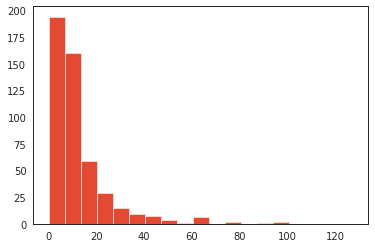

In [16]:
# Hyper Param setting

# token의 Histogram 분포를 바탕으로 대부분의 단어 길이 cover 가능한 단어 개수 찾기
# 신경망 학습을 위한 input 벡터 길이로 사용 - 적정 길이는 tokenizng 이후 분포를 보고 결정(코드 하단)
totalLenSent = [len(x) for x in df_ep_sample['kkma_token']] # 각 document의 단어 길이를 check
plt.hist(totalLenSent,bins = np.arange(0,max(totalLenSent),max(totalLenSent)/20))

print(np.percentile(totalLenSent, 95)) # 95%를 커버하는 수치는 41

# MAX_LEN = int(np.percentile(totalLenSent, 95))
MAX_LEN = 128
print(MAX_LEN)

# pre-trained Embedding을 몇 개 사용할 지 결정
NUM_MODELS = 1

# input data 원문에서 보존할 최대 단어 개수 
# 전체 데이터셋에서 나타나는 unique 한 단어 수(넉넉하게 백단위 올림하여 setting)
from itertools import chain

sum_lists = list(chain.from_iterable(df_ep_sample['kkma_token']))
totalCntWords = int(math.ceil(len(set(sum_lists))/100)*100)

MAX_FEATURES = totalCntWords
print(len(set(sum_lists)), MAX_FEATURES)

## Bert

In [17]:
# !ls ../gdrive/My\ Drive/data/transformers
!ls ../gdrive/My\ Drive/data/bert-based-multilingual-cased

ls: cannot access '../gdrive/My Drive/data/bert-based-multilingual-cased': No such file or directory


In [18]:
!pip install sacremoses sentencepiece 

     |████████████████████████████████| 860kB 3.6MB/s 
     |████████████████████████████████| 1.0MB 29.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=14395f1289f7d353ee0af26649fb7f4ebcde0ffd08062ba2586b4b07e5f2e4c7
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


### Pytorch 환경 내에서 BERT를 사용하기 위한 BERT 관련 Library Load

In [0]:
import sacremoses
import sentencepiece

import pickle
import shutil
from joblib import Parallel, delayed

package_dir_pretrained = "../gdrive/My Drive/data/bert-base-multilingual-cased/"
package_dir_pytorch_bert = "../gdrive/My Drive/data/"
sys.path.append(package_dir_pretrained)
sys.path.append(package_dir_pytorch_bert)

# from transformers import convert_tf_checkpoint_to_pytorch
from transformers import convert_bert_original_tf_checkpoint_to_pytorch

# from transformers import BertTokenizer, BertForSequenceClassification, BertAdam
from transformers.modeling_bert import BertForSequenceClassification
from transformers.tokenization_bert import BertTokenizer
from transformers.optimization import AdamW

from transformers import BertConfig # This is the Bert configuration file

In [20]:
!ls /gdrive/My\ Drive/data/bert-base-multilingual-cased/

bert-base-multilingual-cased-vocab.txt	bert_model.ckpt.meta
bert_config.json			config.json
bert_model.ckpt.data-00000-of-00001	pytorch_model.bin
bert_model.ckpt.index


### Bert 관련 PATH 설정 (모델 PATH, TF CHECK POINT, BERT_CONFIG.JSON 등 로드)

In [21]:
# Translate model from tensorflow to pytorch
BERT_MODEL_PATH = package_dir_pretrained
vocab = 'bert-base-multilingual-cased-vocab.txt'
# BERT_MODEL_PATH bert_config.json file의 설정대로, BERT_MODEL_PATH의 bert_model.ckpt 파일을 load하여 WORK_DIR의 pytorch_model.bin이라는 model로 저장
# A TensorFlow checkpoint (bert_model.ckpt) containing the pre-trained weights (which is actually 3 files).
# A config file (bert_config.json) which specifies the hyperparameters of the model.

print(BERT_MODEL_PATH)

# bert_model.ckpt: tf에서 학습한 bert_model의 check point file,  contains pre-trained weights (with 3 files inside) - bert_model.ckpt.data-00000-of-00001, bert_model.ckpt.index, bert_model.ckpt.meta
# bert_config.json: store hyperparameters
# A vocab file (vocab.txt): map WordPiece to word id
convert_bert_original_tf_checkpoint_to_pytorch.convert_tf_checkpoint_to_pytorch(
    BERT_MODEL_PATH + 'bert_model.ckpt', 
    BERT_MODEL_PATH + 'bert_config.json',
    BERT_MODEL_PATH + 'pytorch_model.bin')

# 읽어온 BERT_MODEL_PATH bert_config.json file의 설정을 그대로 WORK_DIR(현재 작업 디렉터리)의 bert_config.json이라는 이름으로 저장
# following files must be located in that folder: vocab.txt - vocabulary file/ pytorch_model.bin - the PyTorch-compatible (and converted) model/ config.json - json-based model configuration
shutil.copyfile(BERT_MODEL_PATH + 'bert_config.json', BERT_MODEL_PATH + 'config.json')
bert_config = BertConfig(BERT_MODEL_PATH+'config.json')

os.listdir("./") # ['bert_config.json', 'pytorch_bert_model.bin']

../gdrive/My Drive/data/bert-base-multilingual-cased/
Building PyTorch model from configuration: {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 119547
}



INFO:transformers.modeling_bert:Converting TensorFlow checkpoint from /gdrive/My Drive/data/bert-base-multilingual-cased/bert_model.ckpt
INFO:transformers.modeling_bert:Loading TF weight bert/embeddings/LayerNorm/beta with shape [768]
INFO:transformers.modeling_bert:Loading TF weight bert/embeddings/LayerNorm/gamma with shape [768]
INFO:transformers.modeling_bert:Loading TF weight bert/embeddings/position_embeddings with shape [512, 768]
INFO:transformers.modeling_bert:Loading TF weight bert/embeddings/token_type_embeddings with shape [2, 768]
INFO:transformers.modeling_bert:Loading TF weight bert/embeddings/word_embeddings with shape [119547, 768]
INFO:transformers.modeling_bert:Loading TF weight bert/encoder/layer_0/attention/output/LayerNorm/beta with shape [768]
INFO:transformers.modeling_bert:Loading TF weight bert/encoder/layer_0/attention/output/LayerNorm/gamma with shape [768]
INFO:transformers.modeling_bert:Loading TF weight bert/encoder/layer_0/attention/output/dense/bias wit

Save PyTorch model to ../gdrive/My Drive/data/bert-base-multilingual-cased/pytorch_model.bin


['.config', 'sample_data']

### BERT 사용 관련 Hyperparameter Setting

In [0]:
MAX_SEQUENCE_LENGTH = MAX_LEN # token분포 바탕으로 128 선정 (대부분의 단어 길이 cover)
SEED = 1234 # random seed
# NUM_TO_LOAD = len(df_ep_sample) * 0.8 # 전체 데이터셋의 80%를 Train Set으로 활용
EPOCHS = 3
OUTPUT_MODEL_FILE = "../gdrive/My Drive/data/pytorch_bert_media_project_result_model.bin"

# print(NUM_TO_LOAD)

# reproductivity를 위한 seed 고정
lr=2e-5
batch_size = 32
training_epochs = 3 # Number of training epochs (authors recommend between 2 and 4)

In [0]:
# # 기본 Text를 BertTokenizer를 이용하여 Tokenizing

# # aws s3의 bert-base-multilingual-uncased-vocab.txt 파일을 불러와 tokenization 수행
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

# # Make sure all comment_text values are strings
# df_ep_sample['contents'] = df_ep_sample['contents'].astype(str) 

# # train_df의 "comment_text"에서 na를 "DUMMY_VALUE"로 채우고, 최대 MAX_SEQUENCE_LENGTH 만큼 잘라냄
# sequences = convert_bert_token(df_ep_sample["contents"].fillna("DUMMY_VALUE"),MAX_SEQUENCE_LENGTH, tokenizer)

# print(sequences.shape)
# print(df_ep_sample['contents'][:2])
# display(sequences[:2])

In [0]:
# Converting the lines to BERT format # do token-convert-to-ids
# Thanks to https://www.kaggle.com/httpwwwfszyc/bert-in-keras-taming
def convert_bert_token(example, max_seq_length,tokenizer):
    max_seq_length -=2
    all_tokens = []
    longer = 0
    for text in tqdm_notebook(example):
        # print("text :", text)
        tokens_a = tokenizer.tokenize(text)
        print("tokens_a : ", tokens_a)
        if len(tokens_a)>max_seq_length:  #token의 길이가 max_seq_length보다 길면 max_seq_length 뒤로는 잘라내고, longer 변수를 1증가 시킴
            tokens_a = tokens_a[:max_seq_length]
            longer += 1
        # token의 앞 뒤에 [CLS]와 [SEP]을 추가 시키고 남는자리는 zero padding
        # print("max_seq_length: ", max_seq_length, "len(tokens_a): ", len(tokens_a), "max_seq_length - len(tokens_a) : ", max_seq_length - len(tokens_a))

        # """ Converts a token (str/unicode) in an id using the vocab. """
        one_token = tokenizer.convert_tokens_to_ids(["[CLS]"]+tokens_a+["[SEP]"])+ [0] * int(max_seq_length - len(tokens_a)) # token을 vocab을 이용하여 id로 convert
        all_tokens.append(one_token) # all_tokens에 추가
    # print(longer)
    return np.array(all_tokens)

def create_attention_masks(sequence):
# Create attention masks
  attention_masks = []

  # Create a mask of 1s for each token followed by 0s for padding
  for seq in sequence:
    # print("seq is ", seq)
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
  # print(attention_masks)
  return attention_masks

In [25]:
# OKT로 Tokenize 한 데이터를 string으로 붙인 뒤 이를 다시 bert 형태로 tokenizing

%%time
# aws s3의 bert-base-multilingual-uncased-vocab.txt 파일을 불러와 tokenization 수행

# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)
# text : 옷 입고 목욕탕 들어가는거 웃기 넼 저 거 명품 일 텐데
# tokens_a :  ['ᄋ', '##ᅩ', '##ᆺ', '이', '##ᆸ고', 'ᄆ', '##ᅩᆨ', '##요', '##ᆨ', '##타', '##ᆼ', '들어', '##가는', '##거', 'ᄋ', '##ᅮ', '##ᆺ', '##기', '네', '##ᆿ', 'ᄌ', '##ᅥ', 'ᄀ', '##ᅥ', 'ᄆ', '##ᅧᆼ', '##품', '이', '##ᆯ', 'ᄐ', '##ᅦᆫ', '##데']

# tokenizer = BertTokenizer.from_pretrained(os.path.join(cased, vocab), do_lower_case=True, do_basic_tokenize=False)
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True, do_basic_tokenize=False)
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False, do_basic_tokenize=False)

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
# tokens_a :  ['옷', '입', '##고', '목', '##욕', '##탕', '들어', '##가는', '##거', '웃', '##기', '[UNK]', '저', '거', '명', '##품', '일', '텐', '##데']
# tokens_a :  ['[UNK]', '선', '황', '##제', '가', '바', '##람', '은', '못', '[UNK]', '같다', '##는', '생', '##각', '이', '든', '##다', '태', '##후', '가', '황', '##후', '로', '있는', '##한', '감', '##히', '생', '##각', '도', '못', '했', '##을', '##듯']

# Make sure all comment_text values are strings
# df_ep_sample['kkma_token_str'] = df_ep_sample['kkma_token'].apply(lambda x: ' '.join(x))

# train_df의 "comment_text"에서 na를 "DUMMY_VALUE"로 채우고, 최대 MAX_SEQUENCE_LENGTH 만큼 잘라냄
sequences = convert_bert_token(df_ep_sample["okt_token_str"].fillna("DUMMY_VALUE"),MAX_SEQUENCE_LENGTH, tokenizer)
attention_masks = np.asarray(create_attention_masks(sequences))


INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt not found in cache or force_download set to True, downloading to /tmp/tmp7d6jqgjr
100%|██████████| 995526/995526 [00:00<00:00, 5702862.10B/s]
INFO:transformers.file_utils:copying /tmp/tmp7d6jqgjr to cache at /root/.cache/torch/transformers/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729
INFO:transformers.file_utils:removing temp file /tmp/tmp7d6jqgjr
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt from cache at /root/.cache/torch/transformers/96435fa287fbf7e469185f1062386e05a075cadb

tokens_a :  ['옷', '입', '##고', '목', '##욕', '##탕', '들어', '##가는', '##거', '웃', '##기', '[UNK]', '저', '거', '명', '##품', '일', '텐', '##데']
tokens_a :  ['[UNK]', '선', '황', '##제', '가', '바', '##람', '은', '못', '[UNK]', '같다', '##는', '생', '##각', '이', '든', '##다', '태', '##후', '가', '황', '##후', '로', '있는', '##한', '감', '##히', '생', '##각', '도', '못', '했', '##을', '##듯']
tokens_a :  []
tokens_a :  []
tokens_a :  ['이', '게', '나', '##라', '냐', '방송', '에서', '이', '##딴', '수', '##위', '가', '나', '##오', '##고', '지', '##랄', '이', '##야', '진', '##짜', '개', '[UNK]', '조선', '시', '##발']
tokens_a :  ['이', '##엘', '##리', '##야', '님', '진', '##짜', '예', '##쁘', '##다']
tokens_a :  ['오', '##늘', '은', '이', '거', '다']
tokens_a :  ['에', '##쓰', '엠', '드', '##립', '봐']
tokens_a :  ['세', '인', '##데', '저', '정도', '는', '나', '##와', '##줘', '##야', '##지', '댓', '##글', '보고', '졸', '##라', '야', '##한', '##줄', '알', '##았', '##더', '##니', '##만', '미', '##드', '세', '보다', '못', '하', '##네', '청', '##소', '##년', '이야기', '도', '아', '##니', '##고', '나', '##이', '든', '성', '인', '##들', '이'

In [0]:
# print(sequences.shape)
# print(df_ep_sample['okt_token_str'][:2])
# display(sequences[:2])

In [0]:
import torch
import torch.nn as nn # for neural net
import torch.utils.data
import torch.nn.functional as F

from IPython.core.interactiveshell import InteractiveShell # jupyter에서 마지막 값만 출력하는게 아니라 모든 출력값을 매번 연속적으로 출력
InteractiveShell.ast_node_interactivity = "all" # all, last, last_expr, none (기본값은 'last_expr')

In [0]:
# GPU 사용 setting
device=torch.device('cuda')

In [0]:
# BertTokenization 한 Embedding + Target 변수 (Series를 numpy로 변환하면 (x,) 형태의 출력이기 때문에 열 추가를 위해 reshape 해줌)
# all_lines = np.hstack((sequences, df_ep_sample['target'].to_numpy().reshape(-1,1)))
# all_lines.shape

X = sequences
Y = df_ep_sample['target'].to_numpy()
# Y = df_ep_sample['target'].to_numpy().reshape(-1,1)

# Train & Test Set 분리
train_temp_x, test_x, train_temp_y, test_y = train_test_split(X, Y, test_size=0.15, random_state=42)
train_masks, test_masks, _, _ = train_test_split(attention_masks, X, random_state=42, test_size=0.15)
# print(train_temp_x[:1])
# print(train_masks[:1])

train_x, val_x, train_y, val_y = train_test_split(train_temp_x, train_temp_y, test_size=0.15, random_state=42)
train_masks, val_masks, _, _ = train_test_split(train_masks, train_temp_x, random_state=42, test_size=0.15)
# print(train_x[:1])
# print(train_masks[:1])

# print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)
# print(train_masks.shape, val_masks.shape, test_masks.shape)

In [0]:
# np.unique(train_x)
# np.unique(train_y)

In [0]:
# Dataset을 상속한 TensorDataset은 train data x와 레이블 y를 묶어놓은 컨테이너로 tensor만 전달 가능함
# X는 torch.long 형태의 텐서로, y는 torch.float 타입의 텐서로 입력하여 pytorch에서 연산할 수 있는 기본 구조로 변경하여 train_dataset으로 할당
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_x,dtype=torch.long), torch.tensor(train_masks,dtype=torch.long), torch.tensor(train_y,dtype=torch.float))
val_dataset = torch.utils.data.TensorDataset(torch.tensor(val_x,dtype=torch.long), torch.tensor(val_masks,dtype=torch.long), torch.tensor(val_y,dtype=torch.float))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_x,dtype=torch.long), torch.tensor(test_masks,dtype=torch.long), torch.tensor(test_y,dtype=torch.float))

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 평가 헬퍼 함수
def bert_eval_net(net, data_loader, device="cuda"):
  # Dropout 및 BatchNorm 무효화
  net.eval()
  ys = []
  ypreds = []

  eval_losse = 0
  eval_acc = 0

  running_loss = 0.
  running_acc = 0.

  for x, m, y in data_loader:
    x=x.to(device)
    m=m.to(device)
    y=y.to(device)
    with torch.no_grad():
      y_pred = net(x, token_type_ids=None, attention_mask=m, labels=None)  # forward
    y_pred = (y_pred >0.5).float() # bool tensor로 loss 계산이 안되어 float로 변경
    ys.append(y)
    ypreds.append(y_pred)

    loss = F.binary_cross_entropy_with_logits(y_pred.view_as(y),y) 
    running_loss += loss.item() # loss calculate

    running_acc += (y_pred.view_as(y)== y.byte()).sum().item()/ len(x) # 예측 결과 확인(y는 FloatTensor이므로 Byte Tensor로 변환한 후에 비교)

    eval_losses = running_loss/len(data_loader)
    eval_acc = running_acc/len(data_loader)

  # 미니 배치 단위로 예측 결과 등을 하나로 모음
  ys = torch.cat(ys)
  ypreds = torch.cat(ypreds)

  return ys, ypreds, eval_losses, eval_acc

# Train 함수
def bert_train_net(net, train_loader, val_loader, optimizer, device="cuda"):
  train_losses = []
  train_acc = []
  val_losses = []
  val_acc = []

  tq = tqdm_notebook(range(training_epochs))

  for epoch in tq:
    running_loss = 0.
    running_acc = 0.

    # 신경망을 훈련 모드로 설정
    net.train()
    tk0 = tqdm_notebook(enumerate(train_loader),total=len(train_loader),leave=False)
    
    print("Before loop in bert_train_net.................")
    # iteration 1회에 train_loader의 batch_size (여기서는 128)만큼씩 읽어와 한꺼번에 batch처리 batch_size * i (여기서는 i = 482) 가 전체 train data set의 크기가 될때까지 loop
    for i,(x, m, y) in tk0:
      x=x.to(device) # len(x)는 batch_size
      m=m.to(device)
      y=y.to(device)

      loss = net(x, token_type_ids=None, attention_mask=m, labels=y)  # forward

      optimizer.zero_grad() # step과 zero_grad는 쌍을 이루는 것이라고 생각하면 됨 # optimizer의 gradient를 0으로 초기화
      loss.backward() # backpropagation
      optimizer.step() # update gradients
      running_loss += loss.item() # loss calculate

    train_losses.append(running_loss/len(train_loader))
    train_acc.append(running_acc/len(train_loader))

    torch.save(model.state_dict(), OUTPUT_MODEL_FILE)
    
    eval_ys, eval_ypreds, eval_losses, eval_acc = bert_eval_net(net, val_loader, device)
    # val_ypreds = val_ypreds > 0.5
    
    # print(" type(val_ypreds) is ", type(val_ypreds) , "| type(val_ys)  is ", type(val_ys))
    # val_acc.append((val_ypreds.view_as(val_ys) == val_ys.to(device).byte()).sum().item()/len(val_ys))
    val_losses.append(eval_losses)
    val_acc.append(eval_acc)
    print("epoch: {}/{} | avg_train_loss: {:.4f} | avg_train_acc: {:.4f}  |  avg_val_loss: {:.4f} |  avg_val_acc: {:.4f}".format(epoch, training_epochs, train_losses[-1], train_acc[-1], val_losses[-1], val_acc[-1]))

  loss_acc_graph(train_losses, val_losses, train_acc, val_acc)

In [38]:
# BertForSequenceClassification is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. 
# As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

# load pre-trained BERT model's weight in ../
# model = BertForSequenceClassification.from_pretrained(BERT_MODEL_PATH + 'pytorch_model.bin', cache_dir=None, num_labels=len(np.unique(Y)))
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', cache_dir=None, num_labels=len(np.unique(Y)))

# num_training_steps = 100
# num_warmup_steps = 10
# warmup_proportion = float(num_warmup_steps) / float(num_training_steps)  # 0.1

param_optimizer = list(model.named_parameters())

# no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

### In Transformers, optimizer and schedules are splitted and instantiated like this:
# This variable contains all of the hyperparemeter information our training loop needs
# optimizer = AdamW(optimizer_grouped_parameters, lr=lr, warmup=.1)
optimizer = AdamW(optimizer_grouped_parameters, lr=lr, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  # PyTorch scheduler

model.to(device) # GPU 연산을 위해 cuda로 전송

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

bert_train_net(model, train_loader, val_loader, optimizer, device)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json from cache at /root/.cache/torch/transformers/45629519f3117b89d89fd9c740073d8e4c1f0a70f9842476185100a8afe715d1.83b0fa3d7f1ac0e113ad300189a938c6f14d0588a4200f30eef109d0a047c484
INFO:transformers.configuration_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "f

RuntimeError: ignored

In [0]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
ys, ypreds,_,_ = bert_eval_net(net, test_loader, loss_fn ,device)